In [1]:
import torch
import numpy as np
import torch.nn as nn

import os
import imageio
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

In [2]:
def get_rays(datapath, mode="train"):

    datapath = f"/content/drive/MyDrive/ColabNotebooks/NeRF/{datapath}"

    pose_file_names = [f for f in os.listdir(datapath + f'/{mode}/pose') if f.endswith('.txt')]
    intrisics_file_names = [f for f in os.listdir(datapath + f'/{mode}/intrinsics') if f.endswith('.txt')]
    img_file_names = [f for f in os.listdir(datapath + '/imgs') if mode in f]

    assert len(pose_file_names) == len(intrisics_file_names)
    assert len(img_file_names) == len(pose_file_names)

    # Read
    N = len(pose_file_names)
    poses = np.zeros((N, 4, 4))
    intrinsics = np.zeros((N, 4, 4))

    images = []

    for i in range(N):
        name = pose_file_names[i]

        pose = open(datapath + f'/{mode}/pose/' + name).read().split()
        poses[i] = np.array(pose, dtype=float).reshape(4, 4)

        intrinsic = open(datapath + f'/{mode}/intrinsics/' + name).read().split()
        intrinsics[i] = np.array(intrinsic, dtype=float).reshape(4, 4)

        # Read images
        img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.
        images.append(img[None, ...])
    images = np.concatenate(images)

    H = images.shape[1]
    W = images.shape[2]

    if images.shape[3] == 4: #RGBA -> RGB
        images = images[..., :3] * images[..., -1:] + (1 - images[..., -1:])

    rays_o = np.zeros((N, H*W, 3))
    rays_d = np.zeros((N, H*W, 3))
    target_px_values = images.reshape((N, H*W, 3))

    for i in range(N):

        c2w = poses[i]
        f = intrinsics[i, 0, 0]

        u = np.arange(W)
        v = np.arange(H)
        u, v = np.meshgrid(u, v)
        dirs = np.stack((u - W / 2, -(v - H / 2), - np.ones_like(u) * f), axis=-1)
        dirs = (c2w[:3, :3] @ dirs[..., None]).squeeze(-1)
        dirs = dirs / np.linalg.norm(dirs, axis=-1, keepdims=True)

        rays_d[i] = dirs.reshape(-1, 3)
        rays_o[i] += c2w[:3, 3]

    return rays_o, rays_d, target_px_values

In [3]:
def compute_accumulated_transmittance(betas):
    accumulated_transmittance = torch.cumprod(betas, 1)
    return torch.cat((torch.ones(accumulated_transmittance.shape[0], 1, device=accumulated_transmittance.device),
                      accumulated_transmittance[:, :-1]), dim=1)

def rendering(model, rays_o, rays_d, tn, tf, nb_bins=100, device='cpu', white_bckgr=True):

    t = torch.linspace(tn, tf, nb_bins).to(device) # [nb_bins]
    delta = torch.cat((t[1:] - t[:-1], torch.tensor([1e10], device=device)))

    x = rays_o.unsqueeze(1) + t.unsqueeze(0).unsqueeze(-1) * rays_d.unsqueeze(1) # [nb_rays, nb_bins, 3]

    colors, density = model.intersect(x.reshape(-1, 3), rays_d.expand(x.shape[1], x.shape[0], 3).transpose(0, 1).reshape(-1, 3))

    colors = colors.reshape((x.shape[0], nb_bins, 3)) # [nb_rays, nb_bins, 3]
    density = density.reshape((x.shape[0], nb_bins))

    alpha = 1 - torch.exp(- density * delta.unsqueeze(0)) # [nb_rays, nb_bins, 1]

    weights = compute_accumulated_transmittance(1 - alpha) * alpha # [nb_rays, nb_bins]

    if white_bckgr:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]
        weight_sum = weights.sum(-1) # [nb_rays]
        return c + 1 - weight_sum.unsqueeze(-1)
    else:
        c = (weights.unsqueeze(-1) * colors).sum(1) # [nb_rays, 3]

    return c

In [4]:
class Nerf(nn.Module):

  def __init__(self, Lpos=10, Ldir=4, hidden_dim=256):
    super(Nerf, self).__init__()

    self.block1 = nn.Sequential(nn.Linear(Lpos*6 + 3, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU())

    self.block2 = nn.Sequential(nn.Linear(hidden_dim + Lpos*6 + 3, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                nn.Linear(hidden_dim, hidden_dim + 1),)

    self.rgb_head = nn.Sequential(nn.Linear(hidden_dim + Ldir*6 + 3, hidden_dim // 2), nn.ReLU(),
                                  nn.Linear(hidden_dim // 2, 3), nn.Sigmoid())

    self.Lpos = Lpos
    self.Ldir = Ldir

  def positional_encoding(self, x, L):
    out = [x]
    for j in range(L):
      out.append(torch.sin(2 ** j * x))
      out.append(torch.cos(2 ** j * x))

    return torch.cat(out, dim=1)

  def forward(self, xyz, d):

    x_emb = self.positional_encoding(xyz, self.Lpos)
    d_emb = self.positional_encoding(d, self.Ldir)

    h = self.block1(x_emb)
    h = self.block2(torch.cat((h, x_emb), dim=1))
    sigma =h[:, -1]
    h = h[:, :-1]
    c = self.rgb_head(torch.cat((h, d_emb), dim=1))

    return c, torch.relu(sigma)

  def intersect(self, x, d):
    return self.forward(x, d)

## Testing model

In [5]:
test_o, test_d, test_target_px_values = get_rays("fox", mode="test")

<ipython-input-2-5bf22eb51a89>:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(datapath + '/imgs/' + name.replace('txt', 'png')) / 255.


In [6]:
device = "cuda"
tn = 8.
tf = 12.

In [7]:
model = torch.load("/content/drive/MyDrive/ColabNotebooks/NeRF/model_nerf").to(device)

In [8]:
def mse2psnr(mse):
  return 20 * np.log10(1/np.sqrt(mse))

@torch.no_grad()
def test(model, o, d, tn, tf, nb_bins=100, chunk_size=10, H=400, W=400, target=None):

    o = o.chunk(chunk_size)
    d = d.chunk(chunk_size)

    image = []
    for o_batch, d_batch in zip(o, d):
        img_batch = rendering(model, o_batch, d_batch, tn, tf, nb_bins=nb_bins, device=o_batch.device)
        image.append(img_batch) # N, 3
    image = torch.cat(image)
    image = image.reshape(H, W, 3).cpu().numpy()

    if target is not None:
      mse = ((image - target)**2).mean()

    if target is not None:
      return image, mse, mse2psnr(mse)
    else:
      return image

In [9]:
img, mse, psnr = test(model, torch.from_numpy(test_o[8]).to(device).float(), torch.from_numpy(test_d[8]).to(device).float(), tn, tf, nb_bins=100, chunk_size=10,
                target=test_target_px_values[0].reshape(400, 400, 3))
print(psnr)

13.869545766788498


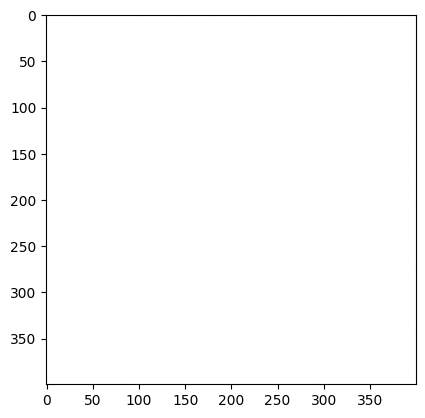

In [10]:
plt.imshow(img)

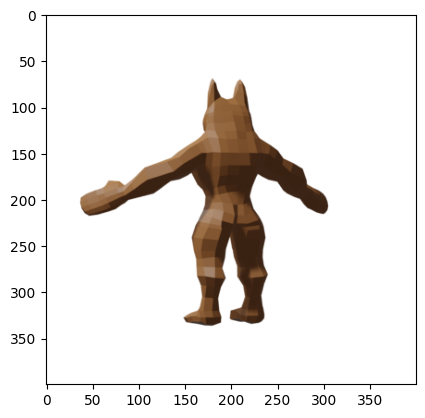

In [11]:
plt.imshow(test_target_px_values[8].reshape(400, 400, 3))